# 0. Load data

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    
def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    Niter:int=100,
                    rebalance:bool=True,
                    subsample=None,
                    measurement_level_name:str='Measurement'):
    if subsample == None:
        subsample = len(df)
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      feature_selection.SelectFromModel(classifier()),
                                      classifier() )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models]
    
import umap

# Suppress batch effects
def scale_by_region(df):
    scaled = []
    for region,_df in df.groupby('Region'):
        _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
        _df = pd.DataFrame(index=_df.index,columns=_df.drop(columns='Region').columns,
                           data=_X)
        _df['Region'] = region
        scaled.append(_df)
    return pd.concat(scaled)
    

In [69]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
figure_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/umap_geom'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = all_df[all_df['Cell type','Meta'] == 'Basal']
basals = basals[~basals['Border','Meta'].astype(bool)]


### Separate measurement fields into constituent types
1. 'geom': Cell geometry
2. 'temporal': Cell rates and lookbacks
3. 'adjac': microenvironment/relative

In [70]:
# Filter only for geom features

meas_names = basals.xs('Measurement',level=1,axis=1).columns
meas_types = pd.DataFrame(index=meas_names)
meas_types['Type'] = 'geom'
meas_types.loc[ meas_names.str.contains('rate'),'Type' ] = 'temporal'
meas_types.loc[ meas_names.str.contains('prior'),'Type' ] = 'temporal'
meas_types.loc[ meas_names.str.contains('adjac'),'Type' ] = 'adjac'
meas_types.loc[ meas_names.str.contains('Relative'),'Type' ] = 'adjac'
meas_types.loc[ meas_names.str.contains('duration'),'Type' ] = 'temporal'
meas_types.loc[ meas_names.str.contains('duration'),'Type' ] = 'Time'
meas_types.loc[ meas_names.str.contains('neighbors'),'Type' ] = 'adjac'

cols2keep = [(f,'Measurement') for f in meas_types[meas_types['Type'] == 'geom'].index]
cols2keep += [(f,'Meta') for f in basals.xs('Meta',axis=1,level=1).columns]
cols2keep += [('Region','')]

basals = basals[cols2keep]

all_meas = basals.xs('Measurement',level=1,axis=1)
all_meas = all_meas.select_dtypes('number')
all_meas[np.isinf(all_meas)] = np.nan
all_meas = all_meas.dropna(axis=1)

all_meas['Region'] = basals['Region']
meas_scaled_by_region = scale_by_region(all_meas)
scaled_data = meas_scaled_by_region.drop(columns='Region')

# 1. Find UMAP configuration

### Try a bunch of hyperparameters

In [ ]:
from itertools import product

_mapped = pd.DataFrame(index=basals.index)
_mapped['Region'] = basals['Region']
_mapped['Cell state'] = basals['Cell cycle phase','Meta']
_mapped.loc[basals['Birth frame','Meta'].astype(bool),'Cell state'] = 'Birth'
_mapped.loc[basals['Divide next frame','Meta'].astype(bool),'Cell state'] = 'Dividing'
_mapped.loc[basals['Will differentiate','Meta'].astype(bool),'Cell state'] = 'Differentiating'
# _mapped.loc[basals['Delaminate next frame','Meta'].astype(bool),'Cell state'] = 'Delaminating'

num_neighbors2try = [2,3,4,5,10]
min_dist2try = [0.0,0.1,0.2,0.5,0.8,1]
parameters = product(num_neighbors2try,min_dist2try)
mapped = []

for num_neighbors,min_dist in tqdm(parameters):
    
    reducer = umap.UMAP(n_neighbors=num_neighbors,min_dist=min_dist)
    embedding = reducer.fit_transform(scaled_data)
    _this_mapped = _mapped.copy()
    
    _this_mapped['Umap1'] = embedding[:,0]
    _this_mapped['Umap2'] = embedding[:,1]
    _this_mapped['Num neighbors'] = num_neighbors
    _this_mapped['Min dist'] = min_dist

    mapped.append(_this_mapped)

mapped = pd.concat(mapped,ignore_index=True)

1it [00:14, 14.11s/it]

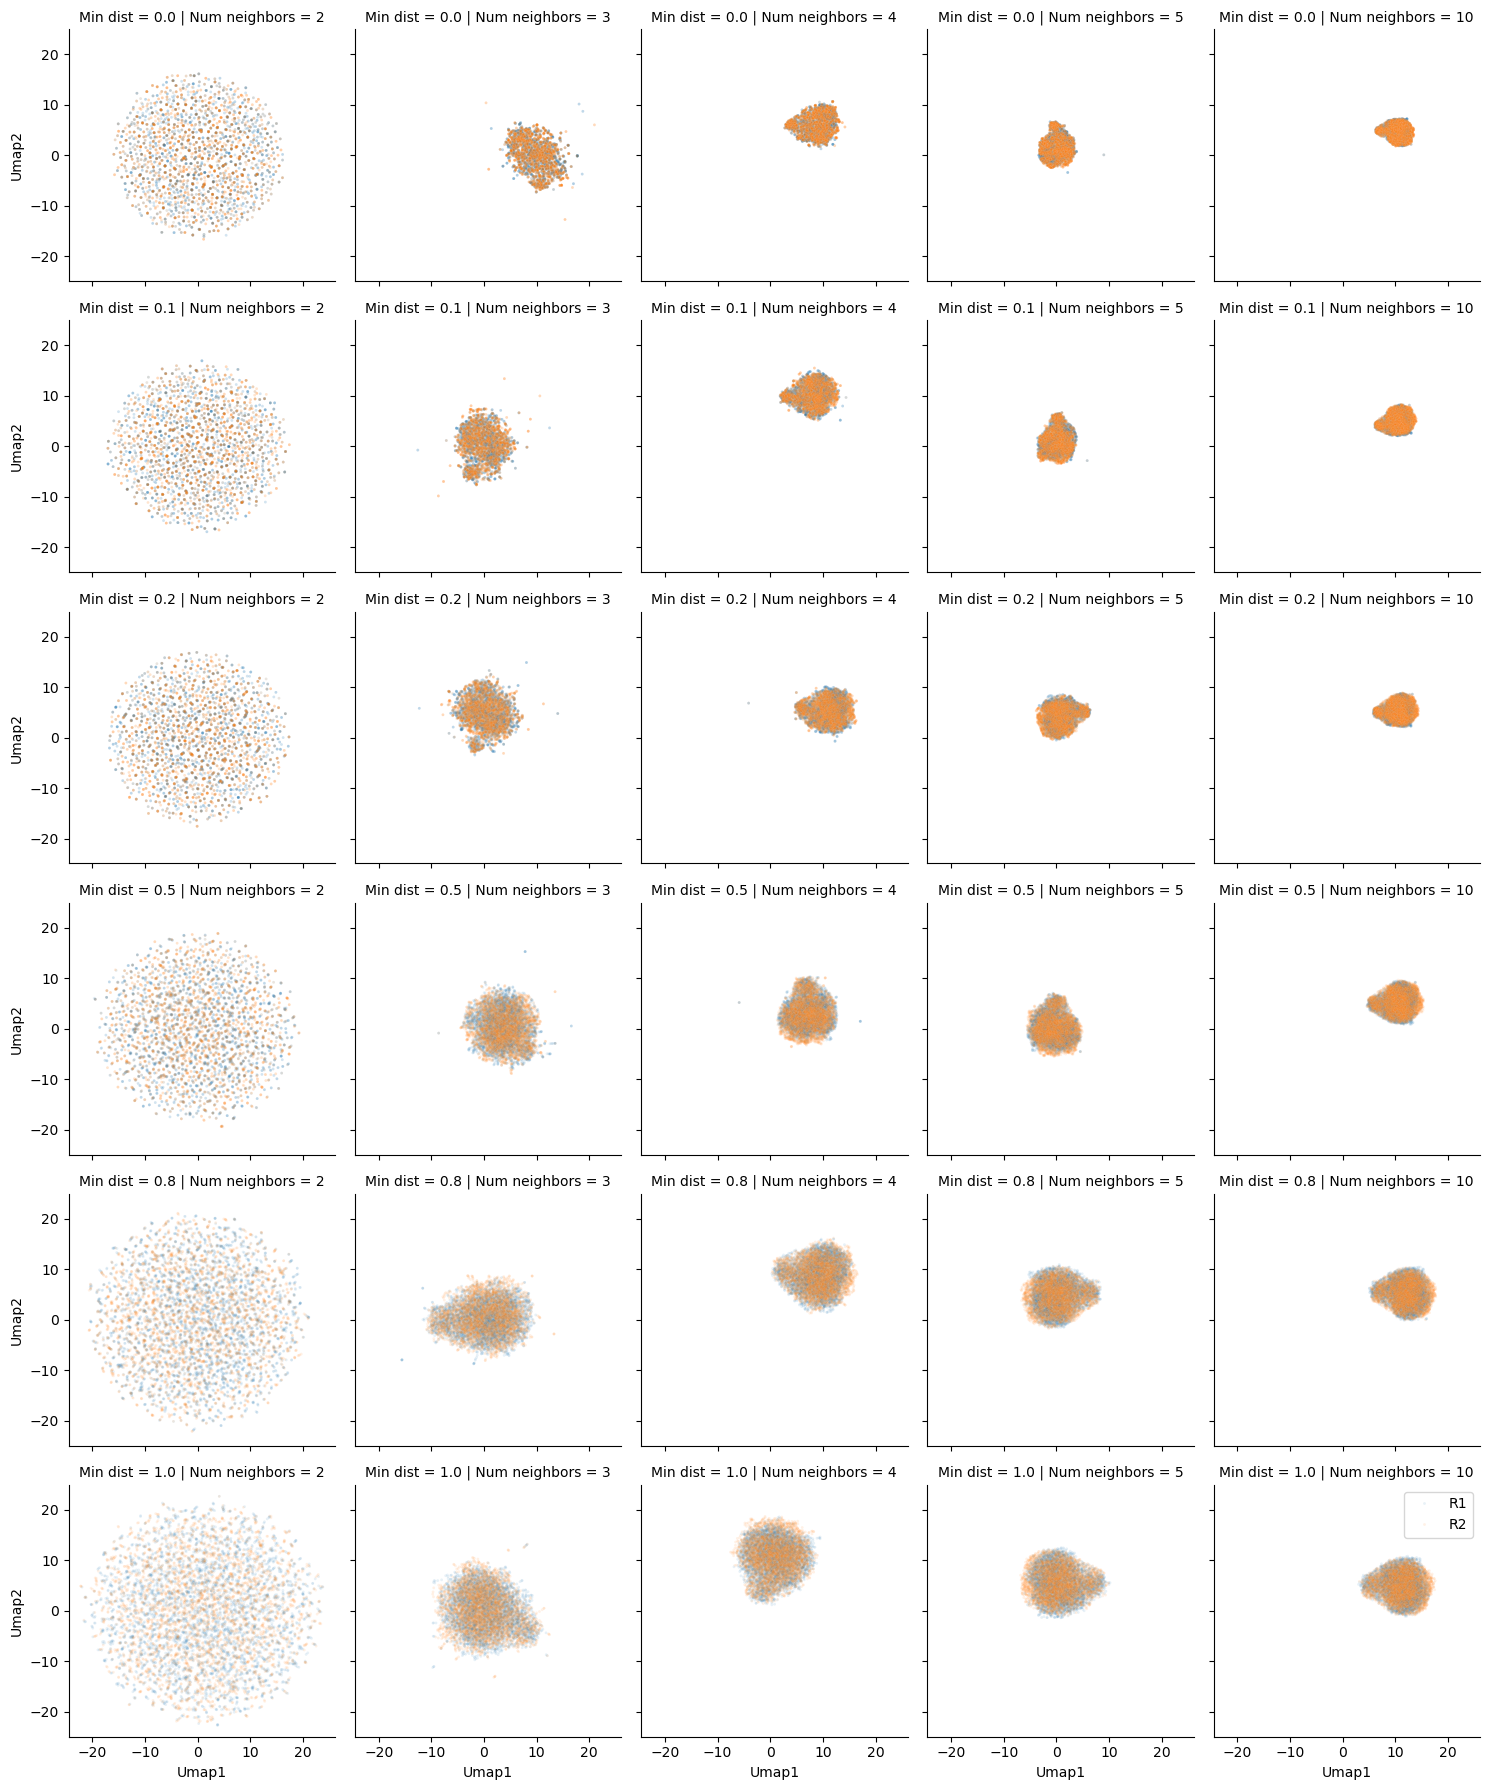

In [10]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped,row='Min dist',col='Num neighbors')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Region',alpha=0.1)
plt.legend()

Num neighbors is much more dominant in determining the structure

### Stability test

In [71]:
Niter = 6

_mapped = pd.DataFrame(index=basals.index)
_mapped['Region'] = basals['Region']
_mapped['Cell state'] = basals['Cell cycle phase','Meta']
_mapped.loc[basals['Birth frame','Meta'].astype(bool),'Cell state'] = 'Birth'
_mapped.loc[basals['Divide next frame','Meta'].astype(bool),'Cell state'] = 'Dividing'
_mapped.loc[basals['Will differentiate','Meta'].astype(bool),'Cell state'] = 'Differentiating'
# _mapped.loc[basals['Delaminate next frame','Meta'].astype(bool),'Cell state'] = 'Delaminating'

mapped = []
for i in tqdm(range(Niter)):
    
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(scaled_data)
    _this_mapped = _mapped.copy()
    
    _this_mapped['Umap1'] = embedding[:,0]
    _this_mapped['Umap2'] = embedding[:,1]
    _this_mapped['Umap run'] = i

    mapped.append(_this_mapped)

mapped = pd.concat(mapped,ignore_index=True)

100%|███████████████████████████████████████████████| 6/6 [00:12<00:00,  2.01s/it]


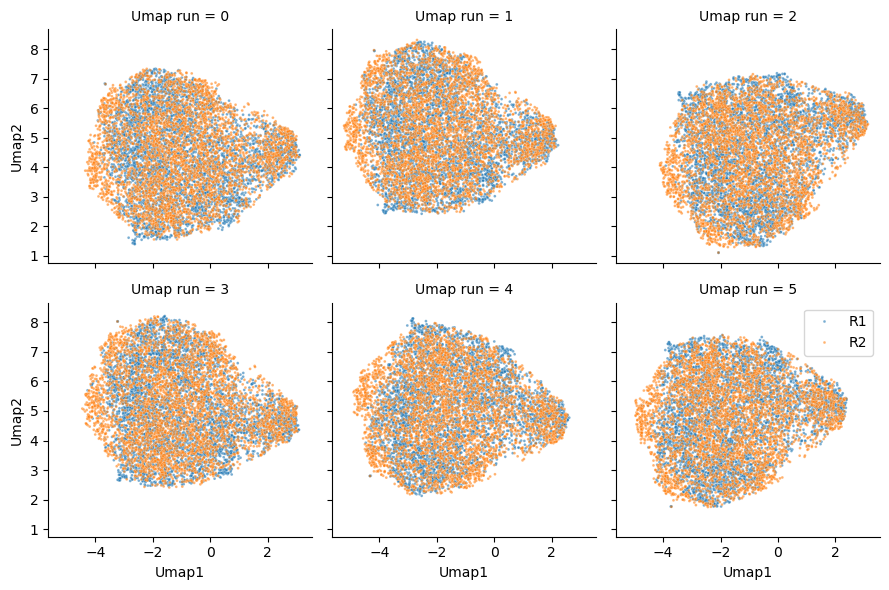

In [72]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped,col_wrap=3,col='Umap run')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Region',alpha=0.6)
plt.legend()

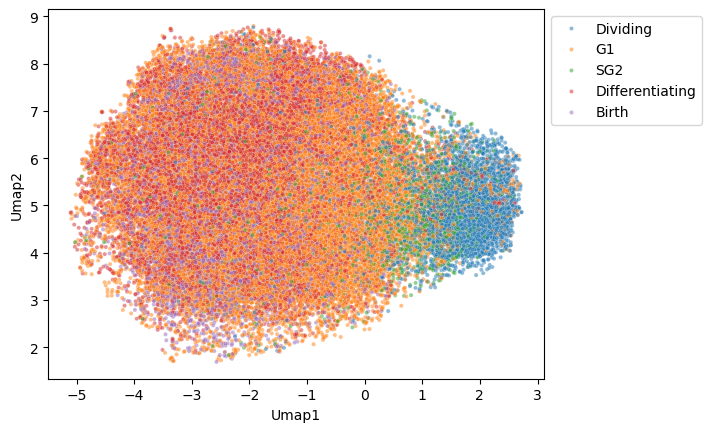

In [7]:
mpl.rcParams['lines.markersize'] = 3              # <---- set markersize here

sb.scatterplot(data=mapped[mapped['Cell state'] != 'NA'],x='Umap1',y='Umap2',
                hue='Cell state',alpha=0.5,)
               # size='Cell state',
               # size_order=['Birth','Dividing','Differentiating','SG2','G1'])
plt.legend(bbox_to_anchor=(1,1))


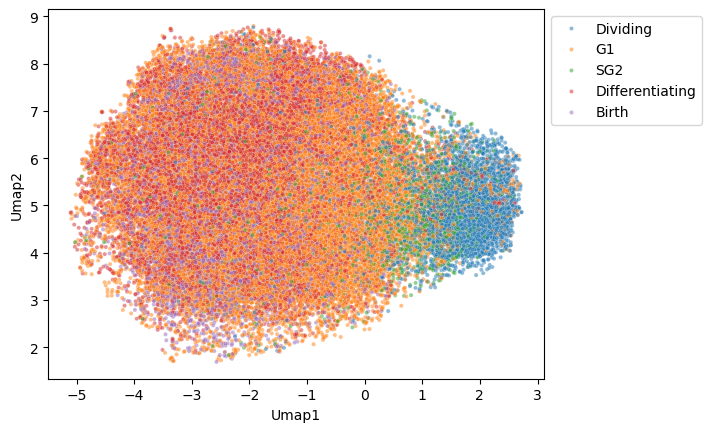

In [8]:
mpl.rcParams['lines.markersize'] = 3              # <---- set markersize here

sb.scatterplot(data=mapped[mapped['Cell state'] != 'NA'],x='Umap1',y='Umap2',
                hue='Cell state',alpha=0.5)
               # size='Cell state',
               # size_order=['Birth','Dividing','Differentiating','SG2','G1'])
plt.legend(bbox_to_anchor=(1,1))


Basicallly, all UMAP runs returns similar graphs

## Visualize UMAPs alongside cell state annotation

In [81]:
mpl.rcParams['lines.markersize'] = 5              # <---- set markersize here

all_meas = basals.xs('Measurement',level=1,axis=1)
all_meas = all_meas.select_dtypes('number')
all_meas[np.isinf(all_meas)] = np.nan
all_meas = all_meas.dropna(axis=1)

all_meas['Region'] = basals['Region']
meas_scaled_by_region = scale_by_region(all_meas)
scaled_data = meas_scaled_by_region.drop(columns='Region')

reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_data)

basals['Umap1'] = embedding[:,0]
basals['Umap2'] = embedding[:,1]


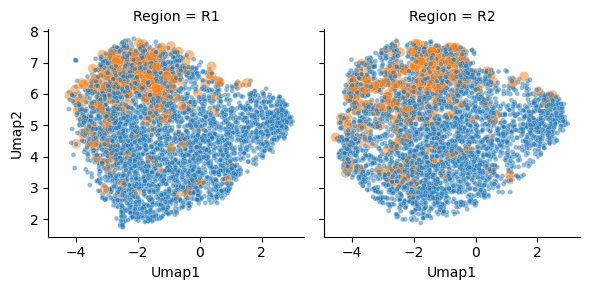

In [82]:
g = sb.FacetGrid(data= basals.droplevel(axis=1,level=1),col='Region')
g.map_dataframe(sb.scatterplot, data = basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Delaminate next frame',alpha=0.5,
              size='Delaminate next frame', size_order=[True,False])

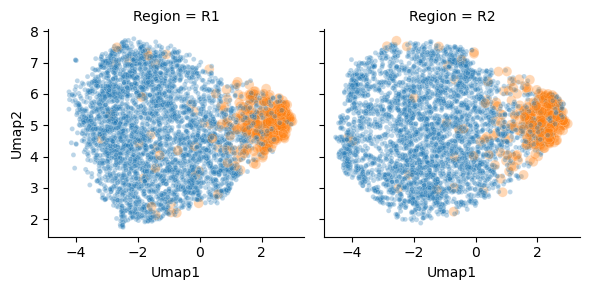

In [83]:

g = sb.FacetGrid(data= basals.droplevel(axis=1,level=1),col='Region')

g.map_dataframe(sb.scatterplot,data=basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Divide next frame',alpha=0.3,
              size='Divide next frame', size_order=[True,False])


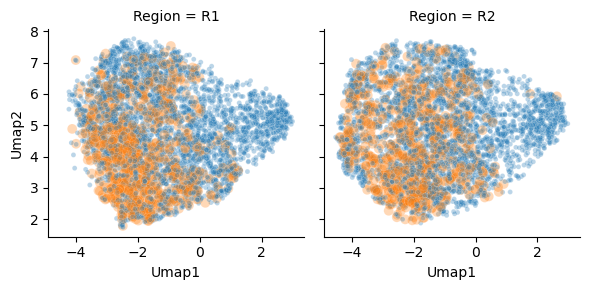

In [84]:

g = sb.FacetGrid(data= basals.droplevel(axis=1,level=1),col='Region')

g.map_dataframe(sb.scatterplot,data=basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Birth frame',alpha=0.3,
              size='Birth frame', size_order=[True,False])


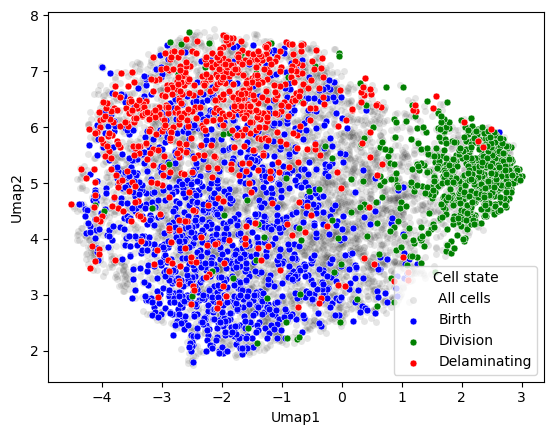

In [85]:
fig, ax = plt.subplots()

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',alpha=0.1, ax=ax, color='k')
sb.scatterplot(basals[basals['Birth frame','Meta']].droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='b',ax=ax)

sb.scatterplot(basals[basals['Divide next frame','Meta']].droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='g',ax=ax)

sb.scatterplot(basals[basals['Delaminate next frame','Meta']].droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='r',ax=ax)

plt.legend(title='Cell state',labels=['All cells','Birth','Division','Delaminating'])


<Axes: xlabel='Umap1', ylabel='Umap2'>

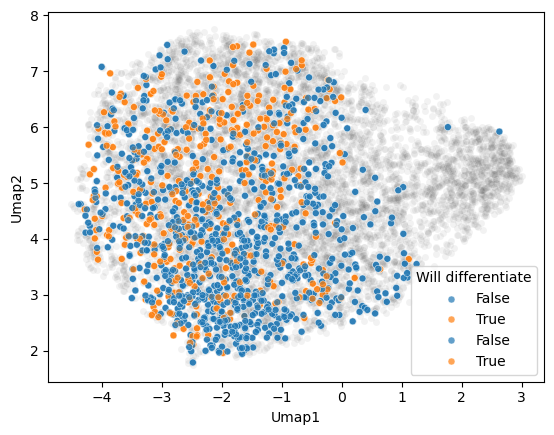

In [86]:
mpl.rcParams['lines.markersize'] = 5              # <---- set markersize here

fig, ax = plt.subplots()

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.05,ax=ax)
_df = basals[basals['Birth frame','Meta']]
sb.scatterplot(_df.droplevel(axis=1,level=1),
               x='Umap1',y='Umap2',alpha=0.7, ax=ax, hue='Will differentiate')

plt.legend(title='Highlighting birth frame:', loc='lower left',
           labels=['','Will divide this cycle', 'Will differentiate'],
          bbox_to_anchor=(1, 0.5))

sb.scatterplot(_df.droplevel(axis=1,level=1),
               x='Umap1',y='Umap2',alpha=0.7, ax=ax, hue='Will differentiate')

<Axes: xlabel='Umap1', ylabel='Umap2'>

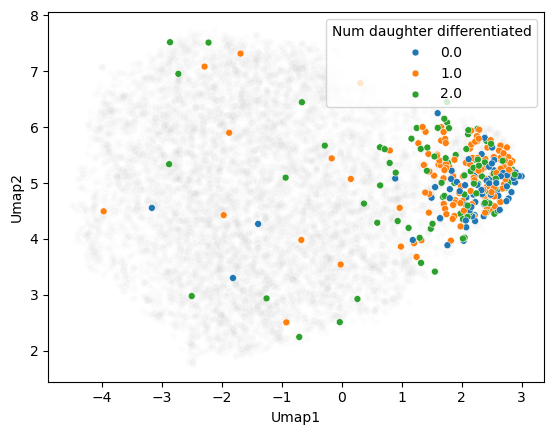

In [87]:

fig, ax = plt.subplots()

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.01,ax=ax)
_df = basals[basals['Divide next frame','Meta']]
sb.scatterplot(_df.droplevel(axis=1,level=1), palette='tab10',
               x='Umap1',y='Umap2',alpha=1, ax=ax, hue='Num daughter differentiated')

# plt.legend(title='Highlighting division frame:', loc='lower left',
#            labels=['','Two dividing daughters','Asymmetric daughters', 'Two differentiating'],
#           bbox_to_anchor=(0, 1))

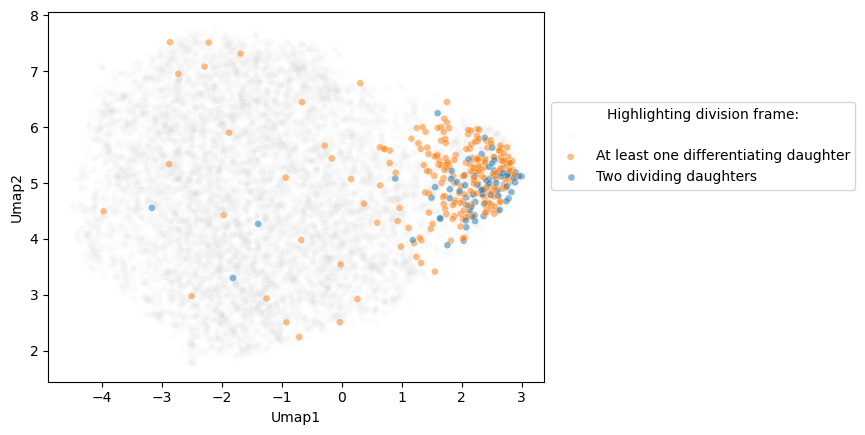

In [88]:
fig, ax = plt.subplots()

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.01,ax=ax)
_df = basals[basals['Divide next frame','Meta']]
sb.scatterplot(_df.droplevel(axis=1,level=1), palette='tab10',
               x='Umap1',y='Umap2',alpha=0.5, ax=ax, hue='At least one daughter differentiated',
              hue_order=[False,True])

plt.legend(title='Highlighting division frame:', loc='lower left',
           labels=['','At least one differentiating daughter','Two dividing daughters'],
          bbox_to_anchor=(1, 0.5))

In [89]:
basals[basals['Fate known','Meta']]

Name          Nuclear volume Nuclear solidity           Z           Y  \
Metadata         Measurement      Measurement Measurement Measurement   
Frame TrackID                                                           
0     R1_2          161.5000         0.879211   44.198142  106.386223   
      R1_5          209.8750         0.911509   44.379690   77.545861   
      R1_11         109.1875         0.854279   44.419576  101.957928   
      R1_19         146.4375         0.875561   45.760990    4.932565   
      R1_24         152.1875         0.897200   45.391786    6.102977   
...                      ...              ...         ...         ...   
13    R2_680        249.5625         0.885562   59.050589   17.805284   
      R2_790        157.2500         0.824107   51.128776   55.967707   
      R2_817        215.1250         0.677826   51.999128  104.740122   
      R2_838        118.1875         0.902625   55.734003   35.136304   
      R2_951        220.9375         0.859888   51.944554   25.618812   

Name                    X Nuclear height Cell volume      Z-cyto      Y-cyto  \
Metadata      Measurement    Measurement Measurement Measurement Measurement   
Frame TrackID                                                                  
0     R1_2      39.835913          -13.0    477.0625   43.777545  106.461254   
      R1_5      97.643389          -13.0    605.9375   44.146983   77.666220   
      R1_11     35.727962          -10.0    444.2500   44.279122  102.201604   
      R1_19     67.557939          -10.0    555.7500   45.823549    4.923105   
      R1_24     79.960164           -9.0    599.6875   45.946326    5.960787   
...                   ...            ...         ...         ...         ...   
13    R2_680    89.724017          -10.0    601.8125   59.633399   17.752337   
      R2_790   107.268979          -11.0    431.0000   51.055539   56.083200   
      R2_817    35.565369          -12.0    730.2500   52.010099  104.987847   
      R2_838    52.346774          -11.0    352.0625   55.727854   35.658042   
      R2_951   103.032815          -11.0    641.6875   51.993085   25.630393   

Name               X-cyto  ... Delaminate next frame  \
Metadata      Measurement  ...                  Meta   
Frame TrackID              ...                         
0     R1_2      40.170935  ...                 False   
      R1_5      97.823672  ...                 False   
      R1_11     35.926210  ...                 False   
      R1_19     67.548752  ...                 False   
      R1_24     79.534158  ...                 False   
...                   ...  ...                   ...   
13    R2_680    89.885736  ...                 False   
      R2_790   107.283389  ...                  True   
      R2_817    35.621191  ...                 False   
      R2_838    52.187156  ...                  True   
      R2_951   103.106993  ...                 False   

Name          Keep until first differentiation Fate known  \
Metadata                                  Meta       Meta   
Frame TrackID                                               
0     R1_2                                 NaN       True   
      R1_5                                 NaN       True   
      R1_11                                NaN       True   
      R1_19                                NaN       True   
      R1_24                                NaN       True   
...                                        ...        ...   
13    R2_680                               NaN       True   
      R2_790                              True       True   
      R2_817                               NaN       True   
      R2_838                              True       True   
      R2_951                               NaN       True   

Name          Frac of neighbors are border Num daughter differentiated  \
Metadata                              Meta                        Meta   
Frame TrackID                                                       

In [322]:
def get_cellID(df,trackID):
    return df.swaplevel(axis=0).loc[trackID,:]

from matplotlib.colors import Normalize
from matplotlib import colormaps,cm
def plot_cell_movement(df,t='Frame',x='X',y='Y',cmap='hot',alpha=0.5,plot_scatter=False,colorbar=False):
    
    df = df.droplevel(axis=1,level=1).sort_values('Frame')
    #calculate displacements
    X = df[x]
    Y = df[y]
    t = df.reset_index()[t].values
    t = t - t[0]
    
    dX = np.diff(X.values)
    dX = np.pad(dX,(0,1),constant_values=np.nan)
    dY = np.diff(Y.values)
    dY = np.pad(dY,(0,1),constant_values=np.nan)

    norm = Normalize(vmin=0,vmax=10,clip=True)
    cmap = colormaps[cmap]
    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    
    plt.axis('equal')
    if plot_scatter:
        plt.scatter(X,Y,color=color)
        
    plt.quiver(X,Y,dX,dY,
               color=cmap(norm(t[1:])),
               alpha=alpha, scale=1, units='xy',headwidth=5)
    
    if colorbar:
        plt.colorbar(sm,ax=plt.gca())
    return


348 tracks will be plotted


348it [00:00, 4669.63it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


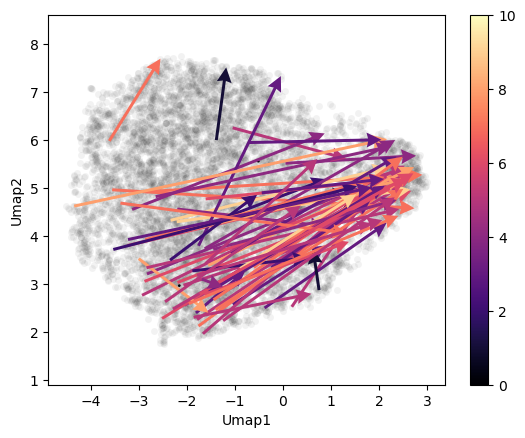

In [323]:
fig, ax = plt.subplots()
from more_itertools import consume

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.05,ax=ax)

all_fate_known_tracks = {trackID:track for trackID,track in basals.swaplevel(axis=0).groupby('TrackID') \
                         if track.iloc[0]['Fate known','Meta'] \
                         if track.iloc[0]['Born','Meta'] \
                         and not track.iloc[0]['Will differentiate','Meta']}

print(f'{len(all_fate_known_tracks)} tracks will be plotted')

first=True
for i,(trackID,track) in tqdm(enumerate(all_fate_known_tracks.items())):
    if (i+1) % 5 == 0:
        plot_cell_movement(track.iloc[[0,-1]],t='Frame',x='Umap1',y='Umap2', alpha=1,
                           cmap='magma',colorbar = first)
        first = False

plt.savefig(path.join(figure_dir,'will_divide.eps'))

len(all_fate_known_tracks) tracks will be plotted


644it [00:00, 8889.28it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


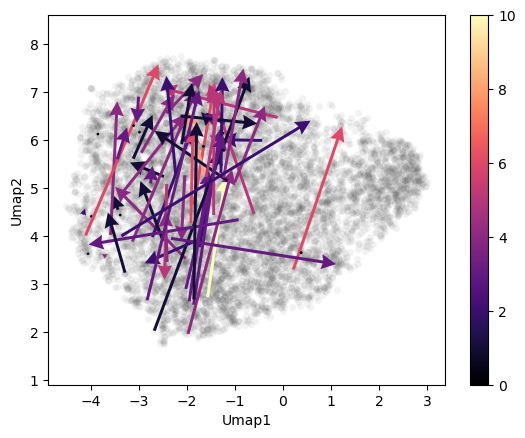

In [324]:
fig, ax = plt.subplots()
from more_itertools import consume

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.05,ax=ax)

all_fate_known_tracks = {trackID:track for trackID,track in basals.swaplevel(axis=0).groupby('TrackID') \
                         if track.iloc[0]['Fate known','Meta'] and track.iloc[0]['Will differentiate','Meta']}
print(f'len(all_fate_known_tracks) tracks will be plotted')

first=True
for i,(trackID,track) in tqdm(enumerate(all_fate_known_tracks.items())):
    if (i+1) % 10 == 1:
        plot_cell_movement(track.iloc[[0,-1]],x='Umap1',y='Umap2', alpha=1, cmap='magma',colorbar=first)
        first= False
        
plt.savefig(path.join(figure_dir,'will_delaminate.eps'))

len(all_fate_known_tracks) tracks will be plotted


73it [00:00, 4664.53it/s]


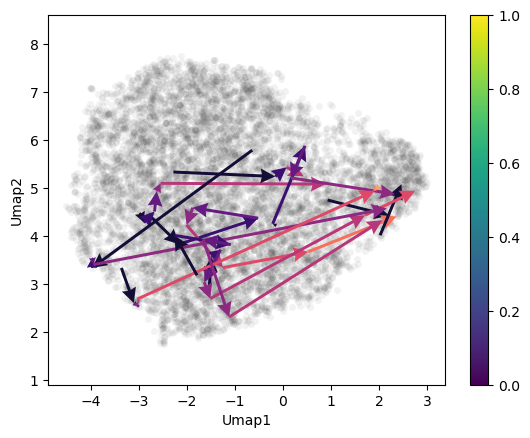

In [325]:
fig, ax = plt.subplots()
from more_itertools import consume

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.05,ax=ax)
# _df = basals.swaplevel(axis=0).loc['R2_838']
# sb.scatterplot(_df.droplevel(axis=1,level=1), palette='tab10',
#                x='Umap1',y='Umap2',alpha=0.5, ax=ax,
#               hue_order=[False,True])

all_fate_known_tracks = {trackID:track for trackID,track in basals.swaplevel(axis=0).groupby('TrackID') \
                         if not np.isnan(track.iloc[0]['Num daughter differentiated','Meta']) and track.iloc[0]['Num daughter differentiated','Meta'] == 0}
print(f'len(all_fate_known_tracks) tracks will be plotted')
for i,(trackID,track) in tqdm(enumerate(all_fate_known_tracks.items())):
    if (i+1) % 5 == 0:
        plot_cell_movement(track,x='Umap1',y='Umap2', alpha=1,cmap='magma')

plt.colorbar()
# plt.legend(title='Highlighting one cell:', loc='lower left',
#            labels=['','At least one differentiating daughter','Two dividing daughters'],
#            bbox_to_anchor=(1, 0.5))

len(all_fate_known_tracks) tracks will be plotted


235it [00:00, 5035.67it/s]


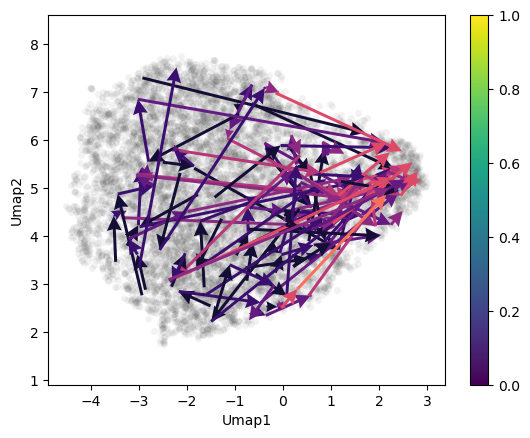

In [326]:
fig, ax = plt.subplots()
from more_itertools import consume

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.05,ax=ax)
# _df = basals.swaplevel(axis=0).loc['R2_838']
# sb.scatterplot(_df.droplevel(axis=1,level=1), palette='tab10',
#                x='Umap1',y='Umap2',alpha=0.5, ax=ax,
#               hue_order=[False,True])

all_fate_known_tracks = {trackID:track for trackID,track in basals.swaplevel(axis=0).groupby('TrackID') \
                         if not np.isnan(track.iloc[0]['Num daughter differentiated','Meta']) and track.iloc[0]['Num daughter differentiated','Meta'] > 0}
print(f'len(all_fate_known_tracks) tracks will be plotted')
for i,(trackID,track) in tqdm(enumerate(all_fate_known_tracks.items())):
    if (i+1) % 5 == 0:
        plot_cell_movement(track,x='Umap1',y='Umap2', alpha=1,cmap='magma')

plt.colorbar()
# plt.legend(title='Highlighting one cell:', loc='lower left',
#            labels=['','At least one differentiating daughter','Two dividing daughters'],
#            bbox_to_anchor=(1, 0.5))

## Isolated frames -> then UMAP

This seems unstable and probably highly dependent on hyperparameters.. did not explore yet

In [327]:
births = births[~births['Border','Meta'].astype(bool)]
divisions = divisions[~divisions['Border','Meta'].astype(bool)]

NameError: name 'births' is not defined

<Axes: xlabel='Umap1', ylabel='Umap2'>

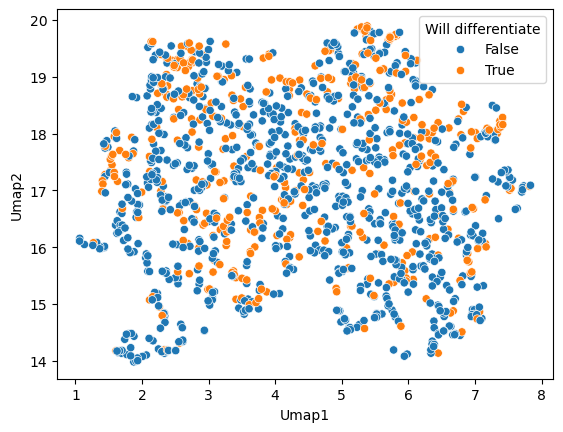

In [47]:
reducer = umap.UMAP()
all_meas = births.xs('Measurement',level=1,axis=1)
all_meas = all_meas.select_dtypes('number')
all_meas[np.isinf(all_meas)] = np.nan
all_meas = all_meas.dropna(axis=1)

scaled_df = preprocessing.StandardScaler().fit_transform(all_meas)
embedding = reducer.fit_transform(scaled_df)
embedding.shape
births['Umap1','Umap'] = embedding[:,0]
births['Umap2','Umap'] = embedding[:,1]

fig, ax = plt.subplots()

sb.scatterplot(births.droplevel(axis=1,level=1),
               x='Umap1',y='Umap2', ax=ax, hue='Will differentiate')


In [41]:
reducer = umap.UMAP()
all_meas = divisions.xs('Measurement',level=1,axis=1)
all_meas = all_meas.select_dtypes('number')
all_meas[np.isinf(all_meas)] = np.nan
all_meas = all_meas.dropna(axis=1)

scaled_df = preprocessing.StandardScaler().fit_transform(all_meas)
embedding = reducer.fit_transform(scaled_df)
embedding.shape
divisions['Umap1','Umap'] = embedding[:,0]
divisions['Umap2','Umap'] = embedding[:,1]
fig, ax = plt.subplots()

sb.scatterplot(divisions.droplevel(axis=1,level=1),
               x='Umap1',y='Umap2', ax=ax, hue='Num daughter differentiated')


<Axes: xlabel='Umap1', ylabel='Umap2'>

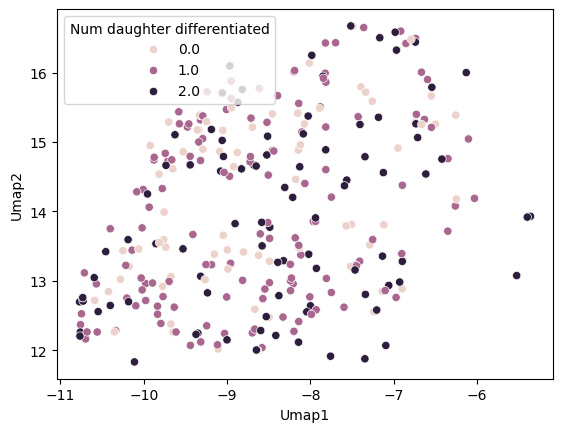

## Try NN graphs

In [333]:
import networkx as nx
from collections import Counter
from sklearn.neighbors import KNeighborsTransformer

def get_mixing_entropy_among_NNs(NN_graph,labels,subset=None):

    # Trim subset if needed
    if not subset is None:
        idx = np.where(subset)[0]
        G = nx.from_numpy_array(NN_graph)
        for i in idx:
            G.remove_node(i)
        
    S = 0
    for i,cell in enumerate(NN_graph):
        self_label = labels[i]
        neighbors = np.where(cell)[0]
        neighbor_labels = labels[neighbors]
    
        # Count occurrences of each label
        l_cnts = Counter(neighbor_labels)
        
        # Convert to probabilities
        total_count = sum(l_cnts.values())
        p = np.array([count/total_count for count in l_cnts.values()])
        
        S += - np.sum(p * np.log(p))
        
    return S
    

In [334]:
NNtransformer = KNeighborsTransformer(n_neighbors=2, mode='distance')
NN = NNtransformer.fit_transform(embedding).toarray()

subset = basals['Birth frame','Meta'].values
bg_entropy = get_mixing_entropy_among_NNs(NN, basals['Will differentiate','Meta'].sample(len(basals)).values, subset=subset)
entropy = get_mixing_entropy_among_NNs(NN, basals['Will differentiate','Meta'].values, subset=subset)
print(f'Background entropy = {bg_entropy}')
print(f'Background entropy = {entropy}')

Background entropy = 2365.018180070492
Background entropy = 1844.46464746991


<Axes: xlabel='Umap1', ylabel='Umap2'>

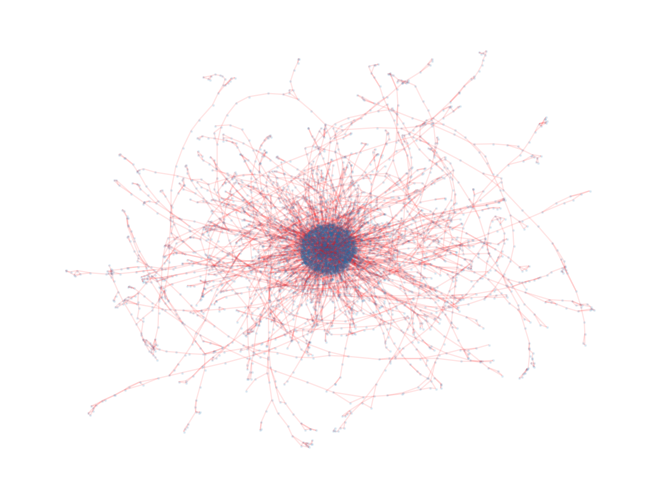

In [335]:
import networkx as nx
G = nx.from_numpy_array(NN)
for idx in np.where(subset)[0]:
    G.remove_node(idx)

nx.draw(G, node_size=1, alpha=0.1, edge_color='r')
sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.1,ax=ax)

In [340]:
NNtransformer = KNeighborsTransformer(n_neighbors=3, mode='distance')
NN = NNtransformer.fit_transform(embedding).toarray()

subset = basals['Divide next frame','Meta'].values
bg_entropy = get_mixing_entropy_among_NNs(NN, basals['At least one daughter differentiated','Meta'].sample(len(basals)).values, subset=subset)
entropy = get_mixing_entropy_among_NNs(NN, basals['At least one daughter differentiated','Meta'].values, subset=subset)
print(f'Background entropy = {bg_entropy}')
print(f'Background entropy = {entropy}')


Background entropy = 8871.264359302084
Background entropy = 8778.242269015775
